In [12]:
# !pip install transformers datasets evaluate rouge_score bert_score matplotlib nltk pandas torch scipy sentencepiece

import torch
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import evaluate
from tqdm.auto import tqdm
import re
import gc

# --- CẤU HÌNH ---
# Model Cũ (Extractive hoặc model đã train trước đó)
MODEL_OLD_PATH = r"D:\do-an-tot-nghiep\models\best_model_combined" # Hoặc đường dẫn Drive
# Model Mới (Phase 2 - Abstractive)
MODEL_NEW_PATH = r"D:\do-an-tot-nghiep\models\final_vit5_model_phase2"

# Dataset chuẩn
DATASET_NAME = "nam194/vietnews" 
# Lưu ý: Nếu mạng lỗi, dùng "nam194/vietnews"

TEST_SAMPLES = 200 # Số lượng mẫu so sánh (None để chạy hết)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2

# Tải NLTK
try: nltk.data.find('tokenizers/punkt')
except LookupError: nltk.download('punkt'); nltk.download('punkt_tab')

print(f"🖥️ Device: {DEVICE}")

🖥️ Device: cuda


In [13]:
print(f"📦 Đang tải dataset: {DATASET_NAME}...")
try:
    dataset = load_dataset(DATASET_NAME, split="test")
except:
    dataset = load_dataset("nam194/vietnews", split="test")

# Chuyển sang Pandas
df = dataset.to_pandas()

# Đổi tên cột về chuẩn (input_text, target_text)
rename_map = {
    "article": "input_text", "abstract": "target_text",
    "document": "input_text", "summary": "target_text",
    "body": "input_text", "content": "input_text"
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})
df = df.dropna(subset=['input_text', 'target_text'])

# Lấy mẫu
if TEST_SAMPLES and len(df) > TEST_SAMPLES:
    df_eval = df.sample(n=TEST_SAMPLES, random_state=42)
else:
    df_eval = df

print(f"✅ Số lượng mẫu đánh giá: {len(df_eval)}")

📦 Đang tải dataset: nam194/vietnews...
✅ Số lượng mẫu đánh giá: 200


In [14]:
def generate_predictions(model_path, data, batch_size=4):
    print(f"\n⏳ Đang load model từ: {model_path}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to(DEVICE)
    except Exception as e:
        print(f"❌ Lỗi load model: {e}")
        return []

    model.eval()
    predictions = []
    
    # Chia batch để chạy
    inputs = data['input_text'].tolist()
    total = len(inputs)
    
    for i in tqdm(range(0, total, batch_size), desc="Generating"):
        batch_texts = inputs[i : i + batch_size]
        
        # Tokenize
        encodings = tokenizer(
            batch_texts, 
            max_length=1024, 
            truncation=True, 
            padding=True, 
            return_tensors="pt"
        ).to(DEVICE)
        
        with torch.no_grad():
            outputs = model.generate(
                **encodings,
                max_new_tokens=128,
                num_beams=2,
                repetition_penalty=2.5,
                no_repeat_ngram_size=3,
                length_penalty=1.0,
                early_stopping=True
            )
            
        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        
        # Tách câu chuẩn NLTK ngay lập tức
        processed = ["\n".join(nltk.sent_tokenize(text.strip())) for text in decoded]
        predictions.extend(processed)
    
    # Dọn dẹp RAM/VRAM
    del model
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    
    return predictions

# --- Xử lý References chuẩn NLTK ---
print("⚙️ Đang xử lý văn bản gốc (References)...")
refs_raw = df_eval['target_text'].tolist()
refs_clean = ["\n".join(nltk.sent_tokenize(str(r).strip())) for r in refs_raw]

⚙️ Đang xử lý văn bản gốc (References)...


In [15]:
# 1. Chạy Model Cũ
print("RUN 1: OLD MODEL")
preds_old = generate_predictions(MODEL_OLD_PATH, df_eval, BATCH_SIZE)

# 2. Chạy Model Mới
print("RUN 2: NEW MODEL (ViT5 Phase 2)")
preds_new = generate_predictions(MODEL_NEW_PATH, df_eval, BATCH_SIZE)

# Kiểm tra độ dài
assert len(preds_old) == len(preds_new) == len(refs_clean)

RUN 1: OLD MODEL

⏳ Đang load model từ: D:\do-an-tot-nghiep\models\best_model_combined


Generating: 100%|██████████| 100/100 [13:44<00:00,  8.25s/it]


RUN 2: NEW MODEL (ViT5 Phase 2)

⏳ Đang load model từ: D:\do-an-tot-nghiep\models\final_vit5_model_phase2


Generating: 100%|██████████| 100/100 [37:25<00:00, 22.46s/it]


In [17]:
print("📊 Đang tính toán điểm số ROUGE & BERTScore...")
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

# Hàm tính nhanh
def compute_metrics(preds, refs, name):
    r_scores = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
    # BERTScore tốn thời gian, có thể bỏ qua nếu muốn nhanh
    b_scores = bertscore.compute(predictions=preds, references=refs, lang="vi")
    bert_f1 = np.mean(b_scores['f1'])
    
    return {
        "Model": name,
        "ROUGE-1": round(r_scores['rouge1'] * 100, 2),
        "ROUGE-2": round(r_scores['rouge2'] * 100, 2),
        "ROUGE-L": round(r_scores['rougeL'] * 100, 2),
        "BERT-F1": round(bert_f1 * 100, 2)
    }

# Tính toán
metrics_old = compute_metrics(preds_old, refs_clean, "Old Model(extractive)")
metrics_new = compute_metrics(preds_new, refs_clean, "New Model(abstractive)")

# Hiển thị bảng so sánh
df_results = pd.DataFrame([metrics_old, metrics_new])
print("\n🏆 BẢNG KẾT QUẢ SO SÁNH:")
display(df_results)

# Tính mức cải thiện
improvement = df_results.iloc[1, 1:] - df_results.iloc[0, 1:]
print("\n📈 MỨC CẢI THIỆN (+/-):")
print(improvement)

📊 Đang tính toán điểm số ROUGE & BERTScore...

🏆 BẢNG KẾT QUẢ SO SÁNH:


,Model,ROUGE-1,ROUGE-2,ROUGE-L,BERT-F1
0,Old Model(extractive),50.48,22.84,30.61,71.33
1,New Model(abstractive),45.17,22.18,27.60,69.22



📈 MỨC CẢI THIỆN (+/-):
ROUGE-1   -5.31
ROUGE-2   -0.66
ROUGE-L   -3.01
BERT-F1   -2.11
dtype: object


In [18]:
# Tạo DataFrame chi tiết
df_detail = pd.DataFrame({
    'Input': df_eval['input_text'].tolist(),
    'Reference': refs_raw,
    'Old_Pred': [p.replace('\n', ' ') for p in preds_old],
    'New_Pred': [p.replace('\n', ' ') for p in preds_new]
})

# Tính ROUGE-L riêng cho từng mẫu để tìm sự chênh lệch
scorer = rouge.compute
diffs = []

print("🔍 Đang tìm các mẫu có sự cải thiện lớn nhất...")
for i in range(len(df_detail)):
    s_old = rouge.compute(predictions=[preds_old[i]], references=[refs_clean[i]])['rougeL']
    s_new = rouge.compute(predictions=[preds_new[i]], references=[refs_clean[i]])['rougeL']
    diffs.append(s_new - s_old)

df_detail['Improvement'] = diffs

# Lấy top 3 mẫu cải thiện tốt nhất
top_improvements = df_detail.sort_values(by='Improvement', ascending=False).head(3)

print("\n--- TOP CÁC MẪU CẢI THIỆN NHIỀU NHẤT ---")
for idx, row in top_improvements.iterrows():
    print(f"📌 Mẫu #{idx}")
    print(f"📉 Old Model: {row['Old_Pred']}")
    print(f"📈 New Model: {row['New_Pred']}")
    print(f"✅ Reference: {row['Reference']}")
    print(f"⭐️ Mức tăng ROUGE-L: +{row['Improvement']*100:.2f}%")
    print("-" * 80)

🔍 Đang tìm các mẫu có sự cải thiện lớn nhất...

--- TOP CÁC MẪU CẢI THIỆN NHIỀU NHẤT ---
📌 Mẫu #167
📉 Old Model: Theo kết_quả điều_tra của công_an, vào đầu tháng 9/2018, Moong Thị_Lý rủ_rê nhiều phụ_nữ trong đó có chị Moong_Thị_M. ( SN 1994, trú cùng bản ) vượt_biên sang Trung_Quốc để bán bào_thai . Ngày 20/9/2518 , khi Moong_thị_LÝ đưa chị M. đi khám thai thì bị tai_nạn giao_thông và sinh con ở Trung_ Quốc . Sau thời_gian điều_trị ngày 2
📈 New Model: Ngày 16/2, Cơ quan CSĐT Công_an huyện Kỳ_Sơn, Nghệ An đã khởi tố bị can đối với Moong Thị_Lý vì tội Tổ chức cho người khác trốn đi nước ngoài. Theo kết quả điều tra, Moong Thị-Lý đã rủ rê nhiều phụ nữ khác sang Trung Quốc để bán bào thai. Chị Moong_Thị_M. và con trai 3 tháng tuổi đã sinh con ở Trung Quốc. Tại cơ quan công_an, Lý thừa nhận hành vi phạm tội của mình và khai báo về việc gặp khó khăn trong quá trình mang thai. Mỗi bàothai sẽ được bán với
✅ Reference: Tại cơ_quan điều_tra , Lý thừa_nhận hành_vi phạm_tội của mình . Bị_can này k

In [20]:
# Cell 7: Compute corpus-level metrics
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

# corpus-level ROUGE
rouge_old = rouge.compute(predictions=preds_old, references=refs_clean, use_stemmer=True)
rouge_new = rouge.compute(predictions=preds_new, references=refs_clean, use_stemmer=True)

def rouge_mid_f(rdict, key):
    val = rdict.get(key)
    if hasattr(val, 'mid'):
        return val.mid.fmeasure
    return val

corpus_metrics = {
    "rouge1_old": rouge_mid_f(rouge_old, "rouge1"),
    "rouge2_old": rouge_mid_f(rouge_old, "rouge2"),
    "rougeL_old": rouge_mid_f(rouge_old, "rougeL"),
    "rouge1_new": rouge_mid_f(rouge_new, "rouge1"),
    "rouge2_new": rouge_mid_f(rouge_new, "rouge2"),
    "rougeL_new": rouge_mid_f(rouge_new, "rougeL"),
}

# BERTScore (may be slow)
berts_old_out = bertscore.compute(predictions=preds_old, references=refs_clean, lang="vi")
berts_new_out = bertscore.compute(predictions=preds_new, references=refs_clean, lang="vi")
corpus_metrics["bertscore_old_f1"] = float(np.mean(berts_old_out["f1"]))
corpus_metrics["bertscore_new_f1"] = float(np.mean(berts_new_out["f1"]))

print("Corpus metrics:")
for k,v in corpus_metrics.items():
    print(f"{k}: {v:.4f}")


Corpus metrics:
rouge1_old: 0.5048
rouge2_old: 0.2284
rougeL_old: 0.3061
rouge1_new: 0.4517
rouge2_new: 0.2218
rougeL_new: 0.2760
bertscore_old_f1: 0.7133
bertscore_new_f1: 0.6922


In [22]:
# Cell 8: Tính per-sample rougeL và bert_f1 (dùng batch cho bertscore)
# rouge per-sample (một mẫu một lần) — chậm nếu test lớn; tối ưu: nhỏ lại hoặc parallelize
def per_sample_rougeL(preds, refs):
    res = []
    for p, r in zip(preds, refs):
        rr = rouge.compute(predictions=[p], references=[r], use_stemmer=True)
        rL_val = rr["rougeL"]
        # Handle both cases: if it's already a float or if it has .mid.fmeasure
        if hasattr(rL_val, 'mid'):
            rL = rL_val.mid.fmeasure
        else:
            rL = float(rL_val)
        res.append(rL)
    return res

print("Computing per-sample rougeL (this may take time)...")
rougeL_old = per_sample_rougeL(preds_old, refs_clean)
rougeL_new = per_sample_rougeL(preds_new, refs_clean)
print("Done rougeL per-sample.")

print("Computing per-sample BERT F1 (batched)...")
# bertscore returns per-sample lists
berts_old = bertscore.compute(predictions=preds_old, references=refs_clean, lang="vi")
berts_new = bertscore.compute(predictions=preds_new, references=refs_clean, lang="vi")
bert_old_f1 = [float(x) for x in berts_old["f1"]]
bert_new_f1 = [float(x) for x in berts_new["f1"]]
print("Done bertscore per-sample.")


Computing per-sample rougeL (this may take time)...
Done rougeL per-sample.
Computing per-sample BERT F1 (batched)...
Done rougeL per-sample.
Computing per-sample BERT F1 (batched)...
Done bertscore per-sample.
Done bertscore per-sample.


In [23]:
# Cell 9: Save detailed CSV để review hoặc human eval
from pathlib import Path
OUTPUT_DIR = Path("outputs/compare_results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

out_csv = OUTPUT_DIR / "predictions_compare.csv"
df_csv = pd.DataFrame({
    "id": list(range(len(df_eval))),
    "document": df_eval['input_text'].tolist(),
    "reference": refs_clean,
    "pred_old": preds_old,
    "pred_new": preds_new,
    "rougeL_old": rougeL_old,
    "rougeL_new": rougeL_new,
    "bert_old_f1": bert_old_f1,
    "bert_new_f1": bert_new_f1
})
df_csv.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("Saved CSV:", out_csv)


Saved CSV: outputs\compare_results\predictions_compare.csv


In [24]:
# Cell 10: Paired bootstrap (mean difference) — kiểm tra ý nghĩa thống kê
BOOTSTRAP_SAMPLES = 1000
SEED = 42

def paired_bootstrap_mean_diff(a_scores, b_scores, n_resamples=1000, seed=42):
    rng = np.random.RandomState(seed)
    n = len(a_scores)
    observed = np.mean(b_scores) - np.mean(a_scores)
    diffs = []
    for _ in range(n_resamples):
        idxs = rng.randint(0, n, n)
        diffs.append(np.mean([b_scores[i] for i in idxs]) - np.mean([a_scores[i] for i in idxs]))
    diffs = np.array(diffs)
    # two-tailed p-value: proportion of diffs with opposite sign or more extreme
    if observed == 0:
        pval = 1.0
    else:
        pval = np.mean(diffs * np.sign(observed) <= 0) * 2
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])
    return observed, pval, (ci_low, ci_high)

# Example: bootstrap on rougeL
obs_rl, p_rl, ci_rl = paired_bootstrap_mean_diff(rougeL_old, rougeL_new, n_resamples=BOOTSTRAP_SAMPLES, seed=SEED)
obs_bs, p_bs, ci_bs = paired_bootstrap_mean_diff(bert_old_f1, bert_new_f1, n_resamples=BOOTSTRAP_SAMPLES, seed=SEED)

print("Bootstrap rougeL: mean_diff(new-old) = {:.6f}, p-value = {:.4f}, 95% CI = ({:.6f}, {:.6f})".format(obs_rl, p_rl, ci_rl[0], ci_rl[1]))
print("Bootstrap bert_f1: mean_diff(new-old) = {:.6f}, p-value = {:.4f}, 95% CI = ({:.6f}, {:.6f})".format(obs_bs, p_bs, ci_bs[0], ci_bs[1]))

# Save summary
summary_txt = OUTPUT_DIR / "summary_results.txt"
with open(summary_txt, "w", encoding="utf-8") as f:
    f.write("Comparison summary\n")
    f.write("==================\n")
    f.write(f"Model old: {MODEL_OLD_PATH}\n")
    f.write(f"Model new: {MODEL_NEW_PATH}\n\n")
    for k,v in corpus_metrics.items():
        f.write(f"{k}: {v}\n")
    f.write("\nBootstrap rougeL: mean_diff(new-old) = {:.6f}, p-value = {:.4f}, 95% CI = ({:.6f}, {:.6f})\n".format(obs_rl, p_rl, ci_rl[0], ci_rl[1]))
    f.write("Bootstrap bert_f1: mean_diff(new-old) = {:.6f}, p-value = {:.4f}, 95% CI = ({:.6f}, {:.6f})\n".format(obs_bs, p_bs, ci_bs[0], ci_bs[1]))
print("Saved summary:", summary_txt)


Bootstrap rougeL: mean_diff(new-old) = -0.030188, p-value = 0.0000, 95% CI = (-0.039054, -0.021267)
Bootstrap bert_f1: mean_diff(new-old) = -0.021026, p-value = 0.0000, 95% CI = (-0.025846, -0.016378)
Saved summary: outputs\compare_results\summary_results.txt


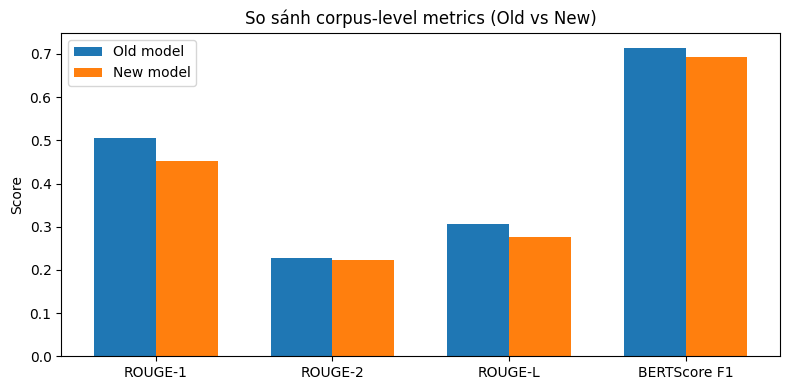

Saved figure: outputs\compare_results\figures\corpus_metrics_bar.png


In [25]:
# Cell 11: Bar chart so sánh corpus-level metrics
FIG_DIR = OUTPUT_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

labels = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore F1"]
old_vals = [corpus_metrics["rouge1_old"], corpus_metrics["rouge2_old"], corpus_metrics["rougeL_old"], corpus_metrics["bertscore_old_f1"]]
new_vals = [corpus_metrics["rouge1_new"], corpus_metrics["rouge2_new"], corpus_metrics["rougeL_new"], corpus_metrics["bertscore_new_f1"]]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x - width/2, old_vals, width, label='Old model')
ax.bar(x + width/2, new_vals, width, label='New model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Score")
ax.set_title("So sánh corpus-level metrics (Old vs New)")
ax.legend()
plt.tight_layout()
fig_path = FIG_DIR / "corpus_metrics_bar.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved figure:", fig_path)


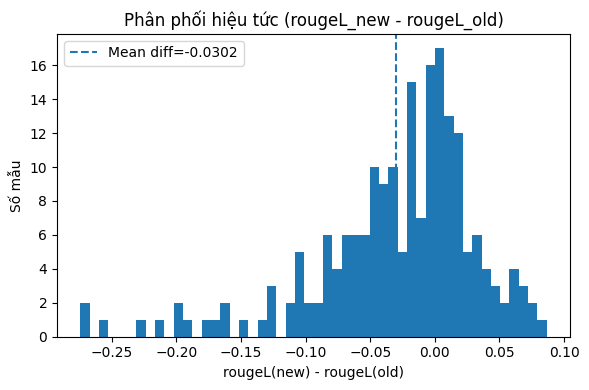

Saved figure: outputs\compare_results\figures\hist_diff_rougeL.png


In [26]:
# Cell 12: Histogram hiệu (new - old) của rougeL per-sample
diffs = np.array(rougeL_new) - np.array(rougeL_old)
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(diffs, bins=50)
ax.axvline(np.mean(diffs), linestyle='--', label=f"Mean diff={np.mean(diffs):.4f}")
ax.set_xlabel("rougeL(new) - rougeL(old)")
ax.set_ylabel("Số mẫu")
ax.set_title("Phân phối hiệu tức (rougeL_new - rougeL_old)")
ax.legend()
plt.tight_layout()
fig_path = FIG_DIR / "hist_diff_rougeL.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved figure:", fig_path)


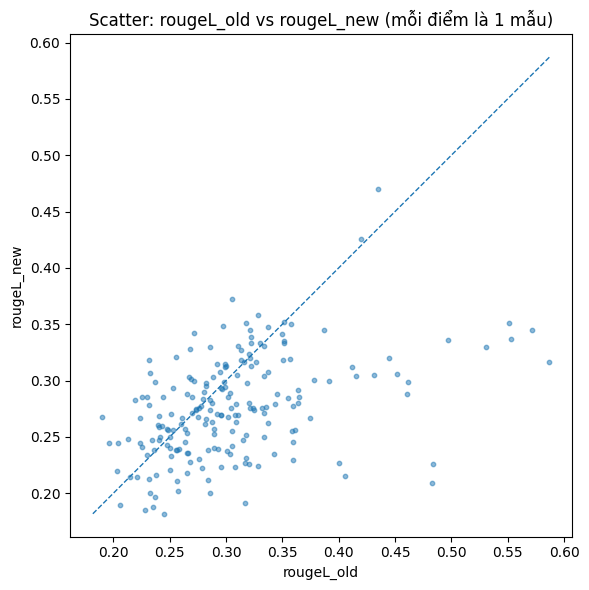

Saved figure: outputs\compare_results\figures\scatter_rougeL_old_new.png


In [27]:
# Cell 13: Scatter plot per-sample rougeL_old vs rougeL_new
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(rougeL_old, rougeL_new, alpha=0.5, s=10)
lim_low = min(min(rougeL_old), min(rougeL_new))
lim_high = max(max(rougeL_old), max(rougeL_new))
ax.plot([lim_low, lim_high], [lim_low, lim_high], linestyle='--', linewidth=1)
ax.set_xlabel("rougeL_old")
ax.set_ylabel("rougeL_new")
ax.set_title("Scatter: rougeL_old vs rougeL_new (mỗi điểm là 1 mẫu)")
plt.tight_layout()
fig_path = FIG_DIR / "scatter_rougeL_old_new.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved figure:", fig_path)


In [28]:
# Cell 14: Show top improvements and worst regressions (theo rougeL diff)
df_csv["rougeL_diff"] = df_csv["rougeL_new"] - df_csv["rougeL_old"]
# top improvements
topN = 5
top_improved = df_csv.sort_values("rougeL_diff", ascending=False).head(topN)
worst = df_csv.sort_values("rougeL_diff", ascending=True).head(topN)

print("Top improvements (new much better):")
display(top_improved[["id","document","reference","pred_old","pred_new","rougeL_old","rougeL_new","rougeL_diff"]])

print("\nTop regressions (new worse):")
display(worst[["id","document","reference","pred_old","pred_new","rougeL_old","rougeL_new","rougeL_diff"]])

# Save examples to HTML for embedding in report if needed
examples_html = OUTPUT_DIR / "examples_top_worst.html"
with open(examples_html, "w", encoding="utf-8") as f:
    f.write("<h2>Top improvements</h2>")
    f.write(top_improved.to_html(escape=False, index=False))
    f.write("<h2>Top regressions</h2>")
    f.write(worst.to_html(escape=False, index=False))
print("Saved examples html:", examples_html)


Top improvements (new much better):


,id,document,reference,pred_old,pred_new,rougeL_old,rougeL_new,rougeL_diff
167,167,"Ngày 16/2 , Cơ_quan CSĐT Công_an huyện Kỳ_Sơn ...","Tại cơ_quan điều_tra , Lý thừa_nhận hành_vi ph...","Theo kết_quả điều_tra của công_an, vào đầu thá...","Ngày 16/2, Cơ quan CSĐT Công_an huyện Kỳ_Sơn, ...",0.231293,0.317949,0.086656
108,108,"Hãng tin Mỹ CNN hôm_nay 8/6 cho_hay , đầu_bếp ...",Đầu_bếp nổi_danh người Mỹ Anthony_Bourdain đã ...,"Theo đó, ông Bourdain được xác_định là đã qua_...","Anthony_Bourdain, một đầu bếp ẩm thực nổi tiến...",0.189781,0.267606,0.077825
17,17,"Ngày 7-12 , trang Economictimes ( Ấn_Độ ) dẫn ...","Lần đầu_tiên trong lịch_sử , đồng_tiền số bitc...","Theo CNBC, thường_xuyên có những khác_biệt đán...",Đồng tiền điện tử (ETC) đã đạt mốc 15.340 USD/...,0.232258,0.306667,0.074409
90,90,"Vào ngày trước Tết_dương_lịch 2017 , tại Geluw...",Thẩm_phán điều_tra thị_trấn Ypres ở Bỉ đã ra_l...,"Vào ngày trước Tết_dương_lịch 2017, tại Geluwe...","Vào ngày trước Tết Dương lịch 2017, tại làng G...",0.271357,0.342593,0.071236
185,185,"Sau khi VN vào tứ_kết , lượng khách đặt mua to...",Hiện nhiều công_ty du_lịch bán tour sang Indon...,Trận tứ_kết thời_điểm này nhiều công_ty đã bán...,"Sau khi Việt Nam vào tứ kết Asiad 2018, lượng ...",0.304878,0.372671,0.067793



Top regressions (new worse):


,id,document,reference,pred_old,pred_new,rougeL_old,rougeL_new,rougeL_diff
55,55,Phó chủ_tịch UBND huyện Cần_Giờ_Trương_Tiến_Tr...,"Chiều nay 23-11 , bão số 9 tiếp_tục mạnh lên ....","Từ sáng mai 24-11, học_sinh Cần_Giờ được nghỉ ...",UBND huyện Cần Giờ đã có thông báo cấm tất cả ...,0.483221,0.208955,-0.274266
187,187,"Báo Thanh_Niên đưa tin , tại phiên_toà xét_xử ...","Trong phiên xét_xử chiều 19/1 , luật_sư Phạm_Q...",Tại phiên_toà xét_xử vụ án chạy thận khiến 9 n...,Tại phiên tòa xét xử vụ án chạy thận khiến 9 n...,0.586957,0.316239,-0.270717
30,30,Bà Park_Geun-hye trình_diện toà_án ở Seoul hôm...,Hàn_Quốc hôm_nay chỉ_định 5 luật_sư quốc_gia b...,Reuters dẫn lời người_phát_ngôn toà_án quận tr...,Bà Park_Geun-hye đã trình diện tòa án ở Seoul ...,0.483660,0.225641,-0.258019
176,176,"Ngày 30/6/2010 , showbiz Hàn chấn_động trước t...","9 năm kể từ khi vụ_việc xảy ra , không nhiều k...","Ngày 30/6/2010, showbiz Hàn chấn_động trước th...","Vào ngày 30/6/2010, showbiz Hàn chấn động trướ...",0.571429,0.345178,-0.226251
27,27,Mới_đây mạng xã_hội Facebook xuất_hiện hình_ản...,Một người phụ_nữ lang_thang có dấu_hiệu bị bện...,Thông_tin nhanh_chóng thu_hút sự chia_sẻ của d...,Vụ việc một phụ nữ mang thai 8 tháng tại Điện ...,0.552632,0.336957,-0.215675


Saved examples html: outputs\compare_results\examples_top_worst.html
